# Linear Programming in Real Life Problems

## Problems 
1. Sudoku 
2. Best Polyhedron 
3. Largest Ball
4. Illumination Problem
5. Jigsaw Puzzle 

In [1]:
# Installation dependencies
!pip3 install numpy==1.18.1 matplotlib==3.1.3 scipy==1.4.1 sklearn
!pip3 install cvxpy==1.0.25 scikit-image==0.16.2

     |████████████████████████████████| 20.2MB 160kB/s 
     |████████████████████████████████| 13.1MB 209kB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.3
    Uninstalling numpy-1.18.3:
      Successfully uninstalled numpy-1.18.3
  Found existing installation: matplotlib 3.2.1
    Uninstalling matplotlib-3.2.1:
      Successfully uninstalled matplotlib-3.2.1


     |████████████████████████████████| 911kB 2.7MB/s 
  Created wheel for cvxpy: filename=cvxpy-1.0.25-cp36-cp36m-linux_x86_64.whl size=2044777 sha256=9e9d8b826210c921263be944df54401b5587c16d23481d3e8c6487899fd0e813
  Stored in directory: /root/.cache/pip/wheels/f1/b0/c3/0d3e98435c5070047e033ead500eb4f93a87c4f3ab6ea6dc1e
Successfully built cvxpy
  Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31


In [0]:
# Compatibility imports
from __future__ import print_function, division

# Imports
import os 
import sys
import random

import numpy as np 
import cvxpy as cp 

import matplotlib.pyplot as plt 

# Modules specific to problems 
from sklearn.datasets import make_circles # For problem 2 (Best Polyhedron) 
from scipy.spatial import ConvexHull # For problem 3 (Largest Ball in Polyhedron)
from scipy.linalg import null_space # For problem 4 (Illumination)
import matplotlib.cbook as cbook # For problem 5 (Jigsaw)
from skimage.transform import resize # For problem 5 (Jigsaw)
from scipy.spatial.distance import mahalanobis
% matplotlib inline

## 1. Sudoku 
- A mixed integer programming algorithm, based upon branch and bound, to solve Sudoku puzzles is implemented here.

The function takes as input a Sudoku puzzle as a 9x9 “list of lists” of integers, i.e.,


    puzzle = [[4, 8, 0, 3, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 7, 1],
              [0, 2, 0, 0, 0, 0, 0, 0, 0],
              [7, 0, 5, 0, 0, 0, 0, 6, 0],
              [0, 0, 0, 2, 0, 0, 8, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 1, 0, 7, 6, 0, 0, 0],
              [3, 0, 0, 0, 0, 0, 4, 0, 0],
              [0, 0, 0, 0, 5, 0, 0, 0, 0]]

where zeros represent missing entries that must be assigned by the algorithm, and all other integers represent a known assignment. 


    
    solved_puzzle = [[4, 8, 7, 3, 1, 2, 6, 9, 5],
                     [5, 9, 3, 6, 8, 4, 2, 7, 1],
                     [1, 2, 6, 5, 9, 7, 3, 8, 4],
                     [7, 3, 5, 8, 4, 9, 1, 6, 2],
                     [9, 1, 4, 2, 6, 5, 8, 3, 7],
                     [2, 6, 8, 7, 3, 1, 5, 4, 9],
                     [8, 5, 1, 4, 7, 6, 9, 2, 3],
                     [3, 7, 9, 1, 2, 8, 4, 5, 6],
                     [6, 4, 2, 9, 5, 3, 7, 1, 8]]
    

In [0]:
class Sudoku():
  def __init__(self):
    super(Sudoku,self).__init__()
    self.puzzle = None # Unsolved sudoku 
    self.solution = None # Store the solution here
    pass

  def construct_solution(self):
    """
      This function created a 9x9 solved sudoku example. 
      It can be used as a reference to see the performance of the solver.
    """
    while True: # until a solved sudoku puzzle if created
      puzzle = np.zeros((9,9))
      rows    = [set(range(1,10)) for i in range(9)] #   set of available
      columns = [set(range(1,10)) for i in range(9)] #   numbers for each
      squares = [set(range(1,10)) for i in range(9)] #   row, column and square

      try:
        for i in range(9): # for each row
          for j in range(9): # for each column

            # Randomly choose a possible number for the location
            choices = rows[i].intersection(columns[j]).intersection(squares[(i//3)*3 + j//3])
            choice  = random.choice(list(choices))

            puzzle[i,j] = choice	# update the puzzle
            
            # Remove from the choice from row,column, square
            rows[i].discard(choice) 
            columns[j].discard(choice)
            squares[(i//3)*3 + j//3].discard(choice)

        # success! every cell is filled.
        return puzzle

      except IndexError:
        # if there is an IndexError, we have worked ourselves in a corner (we just start over)
        continue 
      
  def construct_problem(self,solution,n=28):
    """
      Construct the puzzle by removing a cell if it is possible to deduce a cell's value from the remaining cells 
      @param: n => minimum number of unplucked/remaining cells  
    """

    def canBeDeduced(puz, i, j, c): # check if the cell can be deduced from the remaining cells 
      v = puz[c//9,c%9]
      if puz[i,j] == v: return True
      if puz[i,j] in range(1,10): return False
        
      for m in range(9): # test row, col, square
        # if not the cell itself, and the mth cell of the group contains the value v, then "no"
        if not (m==c//9 and j==c%9) and puz[m,j] == v: return False
        if not (i==c//9 and m==c%9) and puz[i,m] == v: return False
        if not ((i//3)*3 + m//3==c//9 and (j//3)*3 + m%3==c%9) and puz[(i//3)*3 + m//3,(j//3)*3 + m%3] == v:
          return False

      return True


    cells = set(range(81))	
    cellsLeft = set(range(81))

    while len(cells) > n and len(cellsLeft): # Cells in the problem > n and cells left to be plucked > 0	
      cell = random.choice(list(cellsLeft)) # choose a random cell
      cellsLeft.discard(cell)

      # record whether another cell in these groups could also take
      # on the value we are trying to pluck
      row = col = square = False  

      for i in range(9): # For all numbers
        if i != cell/9: # can be deduced from the row
          if canBeDeduced(solution, i, cell%9, cell): row = True
        if i != cell%9: # can be deduced from the col
          if canBeDeduced(solution, cell//9, i, cell): col = True
        if not (((cell//9)//3)*3 + i//3 == cell//9 and ((cell//9)%3)*3 + i%3 == cell%9): # can be deduced from the square
          if canBeDeduced(solution, ((cell//9)//3)*3 + i//3, ((cell//9)%3)*3 + i%3, cell): square = True

      if row and col and square:
        continue # could not pluck this cell, try again.
      else:
        # this is a pluckable cell!
        solution[cell//9][cell%9] = 0 # 0 denotes a blank cell
        cells.discard(cell) # remove from the set of visible cells (pluck it)
        # we don't need to reset "cellsleft" because if a cell was not pluckable
        # earlier, then it will still not be pluckable now (with less information
        # on the board).

    return solution    

**Solution formulation**

Let x<sub>ij</sub> denote the entry in ith row and jth column of the sudoku. x<sub>ij</sub> is a boolean variable. The formulation follows 0 based indexing.

In this problem we aren't worried about maximizing/minimizing any objective function. All we want is any feasible solution that satisfies all the constraints.

So the objective can be just be <b> maximize 0 </b>

The important part of this are the constraints. 

### Constraint over rows - $\sum_{j=1}^{9}$ x <sub>ijk</sub> = 1      for i,k = 0 to 8
This means that the number of times k appears in ith row must be equal to 1. We are doing this for all rows from 0 to 8 and all numbers from 0 to 8. So the total number of constraints because of this = 9*9 = 81.

### Constraint over columns - $\sum_{i=1}^{9}$ x <sub>ijk</sub> = 1      for j,k = 0 to 8
This means that the number of times k appears in jth column must be equal to 1. We are doing this for all columns from 0 to 8 and all numbers from 0 to 8. So the total number of constraints because of this = 9*9 = 81.

### Constraint over 3*3 grid - $\sum_{i=3p}^{3p+3} \sum_{i=3q}^{3q+3}$ x <sub>ijk</sub> = 1      for k = 0 to 8, p,q = 0 to 2
This means that the number of times k appears in (i,j)th cell must be equal to 1. We are doing this for all 3\*3 grids and all numbers from 0 to 8. So the total number of constraints because of this = 9\*3\*3 = 81.

### Constraint for filling all cells - $\sum_{k=1}^{9}$x <sub>ijk</sub> = 1 for i,j = 0 to 8
This means that for each cell (i,j) we must have exactly 1 number from 0 to 8 present in that cell. This ensures that no cell in empty. So total number of constraints for this are - 9*9 = 81.

### Constraint for already present numbers - x <sub>ijk</sub> = 1 for all cells (i,j) which are prefilled with number k
This means that cell (i,j) must be filled with number k. So total number of constraints because of this = Number of prefilled cells in problem.

In the problem formulation x is a 1D vector. x[i\*81+j\*9+k] represents x<sub>ijk</sub>.


In [0]:
class SudokuSolver(Sudoku):
  def __init__(self):
    super(SudokuSolver,self).__init__()
    self.solution = self.construct_solution() # Store the solution here
    self.puzzle = self.construct_problem(self.solution.copy(),n=28) # Unsolved sudoku 
    self.solved = np.zeros((9,9))

  def plot(self):
     """
      Plots the original puzzle, solution using LP and original solution
    """
    print("Puzzle")
    print(self.puzzle)
    print("Solution using LP")
    print(self.solved)
    print("Original Solution")
    print(self.solution)   
 
  def row(self, i, k, x):
    for idx in range(9):
      yield x[i*81 + idx*9 + k]

  def col(self, j, k, x):
    for idx in range(9):
      yield x[idx*81 + j*9 + k]

  def grid(self, p, q, k, x):
    for idx in range(3*p,3*p+3):
      for idy in range(3*q,3*q+3):
        yield x[idx*81 + idy*9 + k]

  def fill_cells(self, i, j, x):
    for k in range(9):
      yield x[i*81 + j*9 + k]

  def solve(self):
    """
      Returns the solved sudoku puzzle 
    """
    x = cp.Variable(9*81 + 9*9 + 9, integer = True)
    objective = cp.Maximize(0)
    # 9x9 sudoku grid
    constraints = []
    # constraints over rows
    for i in range(9):
      for k in range(9):
        constraints.append(sum(self.row(i, k, x)) == 1)
    # constraints over columns
    for j in range(9):
      for k in range(9):
        constraints.append(sum(self.col(j, k, x)) == 1)
    # constraints over 3*3 grid
    for p in range(3):
      for q in range(3):
        for k in range(9):
          constraints.append(sum(self.grid(p, q, k, x)) == 1)
    # constraint for filling all cells
    for i in range(9):
      for j in range(9):
        constraints.append(sum(self.fill_cells(i, j, x)) == 1)
    # constraint for already present numbers
    for i in range(9):
      for j in range(9):
        if self.puzzle[i][j] != 0:
          constraints.append(x[i*81 + j*9 + self.puzzle[i][j] - 1] == 1)
    # constraint that all values in x vector lie in range [0,1]
    for i in range(9):
      for j in range(9):
        for k in range(9):
          constraints.append(x[i*81 + j*9 + k] >= 0)
          constraints.append(x[i*81 + j*9 + k] <= 1)
    problem = cp.Problem(objective, constraints)
    result = problem.solve(solver=cp.GLPK_MI)
    for i in range(9):
      for j in range(9):
        for k in range(9):
          if x[i*81+j*9+k].value > 0:
            self.solved[i][j] = k + 1
    return
    
solver = SudokuSolver()
solver.solve()
solver.plot()

Puzzle
[[0. 0. 0. 0. 8. 3. 0. 0. 1.]
 [5. 0. 2. 0. 0. 4. 3. 8. 0.]
 [0. 0. 7. 0. 2. 0. 6. 0. 0.]
 [1. 0. 6. 0. 3. 0. 7. 0. 9.]
 [0. 0. 8. 1. 5. 0. 0. 0. 2.]
 [3. 4. 5. 0. 9. 0. 0. 0. 0.]
 [9. 0. 3. 6. 1. 0. 2. 0. 8.]
 [0. 0. 4. 0. 7. 9. 1. 6. 0.]
 [6. 0. 0. 3. 0. 2. 0. 7. 0.]]
Solution using LP
[[4. 6. 9. 7. 8. 3. 5. 2. 1.]
 [5. 1. 2. 9. 6. 4. 3. 8. 7.]
 [8. 3. 7. 5. 2. 1. 6. 9. 4.]
 [1. 2. 6. 4. 3. 8. 7. 5. 9.]
 [7. 9. 8. 1. 5. 6. 4. 3. 2.]
 [3. 4. 5. 2. 9. 7. 8. 1. 6.]
 [9. 7. 3. 6. 1. 5. 2. 4. 8.]
 [2. 5. 4. 8. 7. 9. 1. 6. 3.]
 [6. 8. 1. 3. 4. 2. 9. 7. 5.]]
Original Solution
[[4. 6. 9. 7. 8. 3. 5. 2. 1.]
 [5. 1. 2. 9. 6. 4. 3. 8. 7.]
 [8. 3. 7. 5. 2. 1. 6. 9. 4.]
 [1. 2. 6. 4. 3. 8. 7. 5. 9.]
 [7. 9. 8. 1. 5. 6. 4. 3. 2.]
 [3. 4. 5. 2. 9. 7. 8. 1. 6.]
 [9. 7. 3. 6. 1. 5. 2. 4. 8.]
 [2. 5. 4. 8. 7. 9. 1. 6. 3.]
 [6. 8. 1. 3. 4. 2. 9. 7. 5.]]


## 2. Polyhedron

Given two sets of points in R<sub>n</sub>:

$$S1 = \{ x_1, . . . , x_N \}, \space S2 = \{y_1, . . . , y_M\}.$$
The problem is to find a polyhedron
$$P = \{x | \space a_i^T x ≤ b_i, i = 1, . . . , m\}$$
that contains the points in S1 in its interior, and does not contain any of the points in S2:
$$S1 ⊆ \{x | \space a_i^T x < b_i, i = 1, . . . , m\}$$
$$ S2 ⊆ \{x |\space  a_i^T x > b_i \space for \space \space at \space \space least\space\space  one \space i \} = R_n - P.$$

An example is shown in the figure, with the points in S1 shown as open circles and the points in S2 as filled circles. You can assume that the two sets are separable in the way described. 

![alt text](https://drive.google.com/uc?export=view&id=19N_kj6cOXZmaKvlMExOScoqRTPegKODM)

- The solution method returns a_i and b_i, i = 1, . . . , m, given the sets S1 and S2. It is assumed that the polygon doesn't have more than 20 faces. 

In [0]:
class Polyhedron():
  def __init__(self):
    constraints = []
    super(Polyhedron,self).__init__()
    data, labels = make_circles(n_samples=20, noise=0.15,factor=0.3) # This will create our data
    self.S1 = data[labels==0] # Points outside the polyhedron
    self.S2 = data[labels==1] # Points intside the polyhedron

**Solution formulation**

As the maximum number of sides allowed for the polygon are 20, we run a loop from 3 to 20 and solve a separate LP.

Now the equation of lines can be denoted as Ax + By + C = 0. The number of lines is equal to the number of sides of polygon.

So we define 3 variables A,B,C each having size equal to the number of sides.

### Constraints
1. For each point p in S2(points which lie inside the polygon) 

  $Ap$ <sub>x</sub> $ + Bp$<sub>y</sub> + $C <= 0$ (for every line)  
  Now this is not a hard constraint as there might be a case where it is not possible to find a polygon which constains all point in S1. So we can use constraint acctivation for this.

  $Ap$ <sub>x</sub> $ + Bp$<sub>y</sub> + $C - L*f <= 0$
  where L is a very large number and f is a boolean flag. When f = 1, this constraint is deactivated i.e. this point can lie outside the current line.
  
  Total number of constraints because of this = (size of set S2)*(number of sides of polygon)

2. For each point p in S2(points which lie outside the polygon) 

  $Ap$ <sub>x</sub> $ + Bp$<sub>y</sub> + $C >= 0$ (for atleast one line).
  
  To handle the atleast constraint we use constraint activation.

  $Ap$ <sub>x</sub> $ + Bp$<sub>y</sub> + $C  + f1$<sub>side</sub>$*L>= 0$

  If the value of f1<sub>side</sub> is 1 then  this constraint is deactivated i.e this point does not lie outside the current side. 
  
  Total number of constraints because of this = (size of set S1)*(number of sides of polygon)

  But it might be possible that the point lies outside all lines. So we add another constraint.

3. $\sum_{sides} f1 <= sides - 1$ for every point in S1.

  This constraint means that the sum of f1 over all sides must be less that side - 1 i.e atleast one constraint must be activated.

  But it might be possible that it is not possible to find a polygon such the all points in S1 lie outside it. So we use constraint activation in this step too. 

  $\sum_{sides} f1 <= sides - 1 + L * f3*L$
  
  where L is very large number and f3 is boolean variable. When f3 = 1 then this point lies inside the polygon.
      
  Total number of constraints because of this = (size of set S1) 

  ### Objective
  The number of points in S1 which lie outside the polygon must be minimized. So $\sum_{S2}f$ must be minimized.

  Also points in S1 which lie inside polygon must be minimized. So $\sum_{S1}f3$ must be minimized.

  Overall objective = Minimize($\sum_{S2}f + \sum_{S1}f3)$

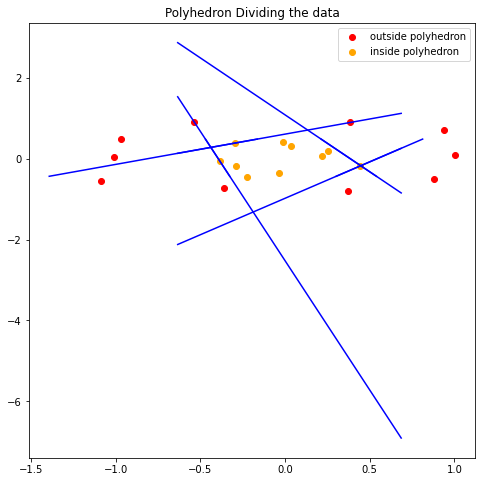

In [18]:
class PolyhedronSolver(Polyhedron):
  def __init__(self):
    super(PolyhedronSolver,self).__init__()
    self.best_a = []
    self.best_b = []
    self.best_c = []
    self.max_x = -1e6
    self.min_x = 1e6
    self.max_y = -1e6
    self.min_y = 1e6
    self.sides  = -1
    self.best_ratio = -1
    pass

  def plot(self):
    """
      Plots the final polyhedron
    """
    fig = plt.figure(figsize=(8,8)) # Create 8x8 inches figure  
    ax = fig.add_subplot(111) # Create a graph inside the figure
    ax.scatter(self.S1[:,0],self.S1[:,1],c="red",label="outside polyhedron") # Plot S1
    ax.scatter(self.S2[:,0],self.S2[:,1],c="orange",label="inside polyhedron") # PlotS2
    self.min_x -= 0.25
    self.min_y -= 0.05
    self.max_x += 0.25
    self.max_y += 0.05
    for i in range(self.sides):
      x = np.array(np.arange(self.min_x,self.max_x,0.01))
      y = (-self.best_c[i] - self.best_a[i]*x)/self.best_b[i] 
      plt.plot(x,y,c='b')
      y = np.array(np.arange(self.min_y,self.max_y,0.01))
      x = (-self.best_c[i] - self.best_b[i]*y)/self.best_a[i] 
      plt.plot(x,y,c='b')
    ax.set_title("Polyhedron Dividing the data")
    plt.legend()
    plt.show()
  def calc_ratio(self,a,b,c, sides):
    """
      Computes the goodness of solution by computing percentage of points in S2 that lie inside the polygon
    """
    counter = 0
    for p in self.S2:
        f = 0
        for i in range(sides):
          if(a[i]*p[0] + b[i]*p[1] + c[i]<= 0):
            f += 1
        if f == sides:
          counter += 1
    return counter / self.S2.shape[0]
  def solve(self):
    for sides in range(4, 20):
      constraints = []
      L = 1e2
      a = cp.Variable(sides)
      b = cp.Variable(sides)
      c = cp.Variable(sides)
      out_total = cp.Variable(self.S2.size, boolean=True)
      in_flag = cp.Variable(self.S2.shape[0], boolean=True)
      out_flag = cp.Variable((self.S1.size, sides), boolean=True)
      x = 0
      # constraint for inner points
      for p in self.S2:
        for i in range(sides):
          self.min_x = min(self.min_x, p[0])
          self.min_y = min(self.min_x, p[1])
          self.max_x = max(self.max_x, p[0])
          self.max_y = max(self.max_x, p[1])
          constraints.append(a[i] * p[0] + b[i] * p[1] + c[i] - L*in_flag[x] <= -0.001)
        x += 1
      x = 0
      # constraint for outer points
      for p in self.S1:
        for i in range(sides):
          constraints.append(a[i] * p[0] + b[i] * p[1] + c[i] + L*out_flag[x][i] >= 0.1)
        x += 1
      constraints.append(cp.sum(out_flag, axis=1) <= sides - 1 + (L*out_total))
      objective = cp.Minimize(cp.sum(out_total) + cp.sum(in_flag))
      problem = cp.Problem(objective, constraints)
      problem.solve()
      ratio = 1
      ratio = self.calc_ratio(a.value,b.value,c.value,  i)
      if ratio > self.best_ratio:
        self.best_ratio = ratio
        self.best_a = a.value
        self.best_b = b.value
        self.best_c = c.value
        self.sides = sides
      if ratio == 1:
        break
    return 
solver = PolyhedronSolver()
solver.solve()
solver.plot()

## 3. Largest Ball in a polyhedron

The largest ball 
$$ B(x_c, R) = \{ x :  ||x − x_c|| ≤ R \}$$
enclosed in a given polyhedron
$$ P = \{ x | a_i^T x ≤ b_i, i = 1, . . . , m\} $$

- The problem variables are the center x<sub>c</sub> ∈ R<sub>n</sub> and the radius R of the ball.


In [0]:
class CircleInPolygon():
  def __init__(self):
     super(CircleInPolygon,self).__init__()
     self.polygon = np.random.random((10,2))
     self.polygon = self.polygon[ConvexHull(self.polygon).vertices,:] # A polygon is stored here

**Solution formulation**

Let c denote the center of the circle and r be the radius. The objective is to maximize the radius.

### Constraints
Let a<sup>T</sup>x = b denote an edge of the polygon. Not the distance of this edge from the centre of the circle must be greater than or equal to r.

$$ {|a^Tc - b| \over ||a||} >= r $$
Two cases are possible,
1. $$a^Tc < b$$
$$a^Tc - b < 0$$
So the constraint converts to, $$ {-a^Tc + b \over ||a||_{2}} >= r $$
$$ {-a^Tc + b} >= ||a||_{2}r $$
$$ \therefore{a^Tc + ||a||_{2}r} <= b $$


2. $$a^Tc > b$$
$$a^Tc - b > 0$$
In this case constraint converts to, , $$ {a^Tc - b \over ||a||_{2}} >= r $$
$$ {a^Tc - b} >= ||a||_{2}r $$
$$ \therefore{a^Tc - ||a||_{2}r} >= b $$

These 2 contraints are disjoint and only one of them must be satisfied at a time. So we use a boolean variable f and a very large value L for this OR constraints.

Final constraints:
$$ {a^Tc - ||a||_{2}r + (1-f)*L} >= b $$ and   $$ {a^Tc + ||a||_{2}r - f*L} <= b $$ 



These constraint must be satisfied for all edges. So the number of constraints = number of edges of polyhedron*2.

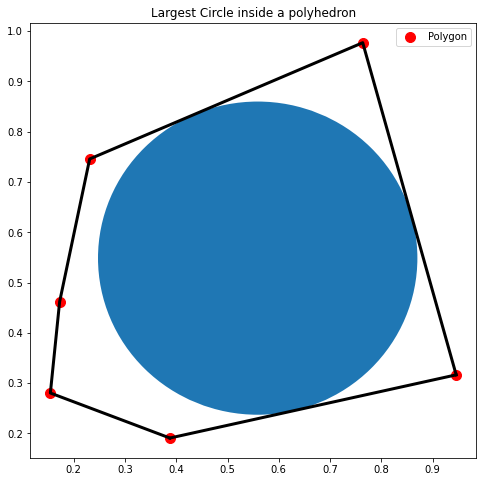

In [20]:
class CircleSolver(CircleInPolygon):
  def __init__(self):
     super(CircleSolver,self).__init__()
     self.r = 0
     self.c = [0,0]

  def plot(self):
    """
     Plots the final result
    """
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax.plot(self.polygon[:,0],self.polygon[:,1],linewidth=3,c="black") # Plot the points
    ax.plot([self.polygon[0,0],self.polygon[-1,0]],[self.polygon[0,1],self.polygon[-1,1]],linewidth=3,c="black") # Plot the edges
    ax.scatter(self.polygon[:,0],self.polygon[:,1],s=100,c="red",label="Polygon") # Plot the edge connecting last and the first point
    circle = plt.Circle((self.c.value[0], self.c.value[1]), self.r.value)
    ax.add_artist(circle)
    ax.set_title("Largest Circle inside a polyhedron")
    plt.legend()
    plt.show()
  def get_line(self, p1, p2):
    """
      Returns equation of line joining 2 points
    """
    a = p2[1] - p1[1]
    b = p1[0] - p2[0]
    c = a*p1[0] + b*p1[1]
    return np.array([a, b]), c 
  def solve(self):
    centre = cp.Variable(2)
    radius = cp.Variable()
    objective = cp.Maximize(radius)
    constraints = []
    L = 1e5
    f = cp.Variable(boolean=True)
    for i in range(len(self.polygon)):  
      a, b = self.get_line(self.polygon[i], self.polygon[(i+1)%len(self.polygon)])
      constraints.append(a.T * centre + radius * np.linalg.norm(a, 2) - f*L  <= b)
      constraints.append(a.T * centre - radius * np.linalg.norm(a, 2) + (1-f)*L  >= b)
    problem = cp.Problem(objective, constraints)
    problem.solve()
    self.r = radius
    self.c = centre
    return
solver = CircleSolver()
solver.solve()
solver.plot()

## 4. Illumination Problem 


We consider an illumination system of m lamps, at positions l<sub>1</sub>, . . . , l<sub>m</sub> ∈ R<sup>2</sup>, illuminating n flat patches. 
The patches are line segments; the ith patch is given by $$[v_i, v_i+1]$$ where v<sub>1</sub>, . . . , v<sub>n+1</sub> ∈ R<sup>2</sup>. The variables in the problem are the lamp powers p<sub>1</sub>, . . . , p<sub>m</sub>, which can vary between 0 and 1.
The illumination at (the midpoint of) patch i is denoted I<sub>i</sub>. We will use a simple model for the illumination:


   $$Ii = \sum_{j=1}^m a_{ij}p_{j} $$
   $$ a_{ij} = r_{ij} ^{-2} ( max(cos \theta_{ij},\theta) )$$
where r<sub>ij</sub> denotes the distance between lamp j and the midpoint of patch i, and θ<sub>ij</sub> denotes the angle between the upward normal of patch i and the vector from the midpoint of patch i to lamp j. 

![alt text](https://drive.google.com/uc?id=1ZyHm9hmKKZRvLryNkiixTEMTCxZts0qH)

This model takes into account “self-shading” (i.e., the fact that a patch is illuminated only by lamps in the halfspace it faces) but not shading of one patch caused by another. Of course we could use a more complex illumination model, including shading and even reflections. This just changes the matrix relating the lamp powers to the patch illumination levels.

The problem is to determine lamp powers that make the illumination levels close to a given desired illumination level Ides, subject to the power limits 0 ≤ p<sub>i</sub> ≤ 1. Suppose we use the maximum deviation

####   $$ \varphi(p) = max_{k=1,...,n} |I_{k} - I_{des}| $$

The problem is to compute a feasible p using this first method, and then calculate $\varphi(p)$



In [0]:
class Illumination():
  def __init__(self):
    super(Illumination,self).__init__()

    # Lamp position
    self.Lamps = np.array([[0.1 ,0.3, 0.4, 0.6 ,0.8 ,0.9 ,0.95],[1.0, 1.1, 0.6 ,0.9, 0.9 ,1.2, 1.00]])
    self.m = self.Lamps.shape[1]    # number of lamps

    # begin and endpoints of patches  
    self.patches = [np.arange(0,1,1/12),np.array([0 ,0.1 ,0.2, 0.2, 0.1, 0.2 ,0.3 ,0.2 ,0 ,  0 ,  0.2, 0.1])]
    self.patches = np.array(self.patches)
    self.n = self.patches.shape[1] -1  # number of patches

    # desired illumination
    self.Ides = 2;

    # construct A
    self.dpatches = self.patches[:,1:] - self.patches[:,:-1];  # tangent to patches
    self.patches_mid = self.patches[:,1:] - 0.5*self.dpatches;         # midpoint of patches
    A = np.zeros((self.n,self.m));
    for i in range(self.n):
      for j in range(self.m):
        dVI = self.Lamps[:,j]-self.patches_mid[:,i] # Find the distance between each lamp and patch 
        rij = np.linalg.norm(dVI,ord=2) # Find the radius/distance between lamp and the midpoint of the patch 
        normal = null_space(self.dpatches[:,i].reshape(1,2)) # Find the normal

        if normal[1] < 0: # we want an upward pointing normal  
          normal = -1*normal
        A[i,j] = dVI.dot(normal)/(np.linalg.norm(dVI,ord=2)*np.linalg.norm(normal,ord=2))/(rij**2); # Find A[i,j] as defined above
        if A[i,j] < 0: 
          A[i,j] = 0

    self.A = A

**Solution formulation**
### Constraints
Let power denote the array containing the power of the lamps. 

$power[i] >= 0$ and $power[i] <= 1$   for i from 1 to number_of_lamps

The objective is essentially to minimize the L<sub>$\infty$</sub> norm of $|Ides - Illumination|$ over all patches. This can be written as $|Ides - Illumination[i]| <= t$ for i from 1 to number_of_patches

OR 

$Ides - Illumination[i] <= t$ and $Ides - Illumination[i]| >= -t$ for i from 1 to number_of_patches

### Objective
As the objective is to minimize L<sub>$\infty$</sub> norm of |Ides - Illumination| over all patches, we can simply minimize t as it is the upper bound on $|Ides - Illumination[i]|$.


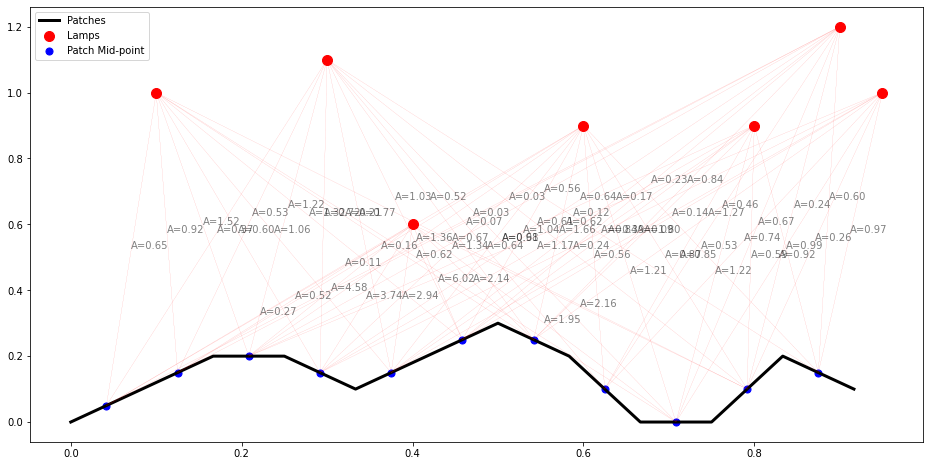

p = 1.00000e+00, 6.63701e-01, 2.82754e-23, -1.94095e-23, 2.07786e-23, 2.65217e-01, 1.00000e+00
phi(p) =  1.09104e+00


In [22]:
class IlluminationSolver(Illumination):
  def __init__(self):
    super(IlluminationSolver,self).__init__()

  def plot(self):
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(111)
     
    ax.scatter(self.Lamps[0,:],self.Lamps[1,:],s=100,c="red",label="Lamps") # Lamps
    ax.scatter(self.patches_mid[0,:],self.patches_mid[1,:],s=50,c="blue",label="Patch Mid-point") # Lamps
    ax.plot(self.patches[0,:],self.patches[1,:],linewidth=3,c="black",label="Patches") # Patches

    # Normal joining lamps and patchs 
    for i in range(self.n):
      for j in range(self.m):
        if self.A[i,j] > 0:
          ax.plot([self.Lamps[0,j], self.patches_mid[0,i]],[self.Lamps[1,j], self.patches_mid[1,i]],'r--',linewidth=0.1,alpha=1)
          ax.text((self.Lamps[0,j]+self.patches_mid[0,i])/2,(self.Lamps[1,j] + self.patches_mid[1,i])/2,"A={0:.2f}".format(self.A[i,j]),alpha=0.5)

    plt.legend()
    plt.show()
  
  def solve(self):
    I = []
    power = cp.Variable(self.m)
    t = cp.Variable()
    for i in range(self.n):
      a = 0
      for j in range(self.m):
        a += (self.A[i][j] * power[j])  #filling illumination array
      I.append(a)
    constraints = []
    for i in range(self.m):
      # constraint on power range
      constraints.append(power[i] >= 0)
      constraints.append(power[i] <= 1)
    for i in range(self.n):
      constraints.append(I[i] - self.Ides <= t)
      constraints.append(I[i] - self.Ides >= -t)
    objective = cp.Minimize(t)
    problem = cp.Problem(objective, constraints)
    problem.solve()
    print("p = ", end = '')
    print(', '.join(['{:.5e}'.format(x) for x in power.value]))
    print("phi(p) = ",'{:.5e}'.format(t.value) )
    return
solver = IlluminationSolver ()
solver.plot()
solver.solve()

## 5. Jigsaw 

Solving jigsaw puzzles computationally remains a relevant and intriguing problem noted for its applications to real-world problems. 

In this problem, we implement a solver that solves jigsaw puzzles using linear programming. 

The current problem requires you to only solve Type I problems (i.e. problems where the orientation of the pieces is known).

For implementation details refer [Solving Jigsaw Puzzles with Linear Programming](https://arxiv.org/abs/1511.04472). 

![alt text](https://drive.google.com/uc?id=19MyWwH6XV4jz244E5yBJAH0baZAXddVx)

- Jigsaw class will take an image as input and will create a random jigsaw puzzle. Function patches2image will reconstruct the image back from the patches


In [0]:
class Jigsaw():
  def __init__(self,path=None):
    super(Jigsaw,self).__init__()
    """
      Initialize your Jigsaw puzzle, you can provide path to an image or we will load the default image
    """
    if path is None:  # Load default image  
      with cbook.get_sample_data('grace_hopper.png') as image_file:
        self.image = plt.imread(image_file)
    else:
      self.image = plt.imread(path)  # Load image of your choice

    self.original_size = self.image.shape[0:2] #Store the original size of the image
    self.new_size = (500,500) # Store new image size, 500x500
    self.rows = 5 # number of rows in jigsaw puzzle
    self.cols = 5 # number of cols in jigsaw puzzle

    # RxCxHxWx3 numpy array storing the jigsaw puzzle
    self.jigsaw = self.create_jigsaw_puzzle(self.image,self.new_size,self.rows,self.cols)
  
  def image2patches(self,image,new_size,rows,cols):
    """
      This function converts an image to patches for jigsaw puzzle
      @param: image -> input image
      @param: new_size -> shape to which image will be resized
      @param: rows -> number of rows in the jigsaw puzzle
      @param: rows -> number of cols in the jigsaw puzzle

      @returns: patches -> RxCxHxWx3 numpy array storing the jigsaw puzzle's patches
    """

    image = resize(image,self.new_size) # resize the original image 
    patches = np.zeros((self.rows,self.cols,self.new_size[0]//self.rows,self.new_size[1]//self.cols,3)) # store the jigsaw puzzle here
    for i in range(self.rows): # for every row of jigsaw
      for j in range(self.cols): # for every col of jigsaw
        patches[i,j,:,:,:] = self.image[i*self.new_size[0]//self.rows:(i+1)*self.new_size[0]//self.rows,j*self.new_size[0]//self.cols:(j+1)*self.new_size[0]//self.cols,:]
    return patches 

  def patches2image(self,patches,original_size):
    """
      This function recreates images from patches
      @param: patches -> RxCxHxWx3 numpy array storing the jigsaw puzzle's patches
      @param: orignal_size -> shape to which image will be resized

      @returns: image -> output image 
    """
    R,C,H,W,_ = patches.shape
    image = np.zeros((R*H,C*W,3))
    for i in range(R):
      for j in range(C):
        image[i*H:(i+1)*H,j*W:(j+1)*W,:] = patches[i,j,:,:,:] 
    
    image = resize(image,original_size) 
    return image 

  def create_jigsaw_puzzle(self,image,new_size,rows,cols):
    patches = self.image2patches(image,new_size,rows,cols)
    R,C,H,W,_ = patches.shape
    patches = patches.reshape((-1,H,W,3))
    patches = patches[np.random.permutation(R*C),...].reshape((R,C,H,W,3))
    return patches

**Solution formulation**

The entire formulation is same as mentioned in [Solving Jigsaw Puzzles with Linear Programming](https://arxiv.org/abs/1511.04472).

Blocks in jigsaw puzzle are matched pairwise using image intensity information. This part uses linear programming.

The next part is image assembly.

Any 2 pair of images can have 4 possible orientations.

  1. Image i below image j
  2. Image i to the left of image j
  3. Image i above image j
  4. Image i to the right of image j

This information can be encoded using 3d indices (i, j, o) where i, j are pair of images and o is the orientation. o = {1, 2, 3, 4}.

We define desired offset for each orientation using dx = {0, -1, 0, 1} and dy = {1, 0, -1, 0}.

Let x[i], y[i] be variables which denote the position of ith jigsaw puzzle in the reconstructed image.

We define D<sub>ijo</sub> as MGC distance between pieces i and j with orientation o. The matching weight wijo associated with the oriented pair (i, j, o) can now be computed
as

$w$<sub>ijo</sub>$= min(min$<sub>k$\neq$i</sub>($D$<sub>kjo</sub>), $min$<sub>k$\neq$j</sub>($D$<sub>iko</sub>)))$/D$<sub>ijo</sub>

We also define a few sets

  * $ V = \{i | i = 1,..,N*M\} $
  * $ U = \{(i, j, o) | i \in V, j \in V, o \in\{0, 1, 2, 3\}  \} $
  * $ A = \{(i,j,o)\in U : j = argmin_{(i,j,o)\in U}(D_{ijo}\} $
  * $ R = \{(i,j,o)\in A : |x_i-x_j-dx_o| > 10^{-5} or |y_i-y_j-dy_o| > 10^{-5}\} $



### Objective

- $C(x) = \sum_{(i,j,o) in U} w$<sub>ijo</sub>$|x$<sub>i</sub>$-x$<sub>j</sub>$-dx$<sub>o</sub>$|$<sub>0</sub>

- $C(y) = \sum_{(i,j,o) in U} w$<sub>ijo</sub>$|y$<sub>i</sub>$-y$<sub>j</sub>$-dy$<sub>o</sub>$|$<sub>0</sub>

And the objective is -
 $Minimize [C(x) + C(y)]$

### Constraints
- $1 <= x_i <= number\_of\_rows$ for all i

- $1 <= y_i <= number\_of\_columns$ for all i

- $|x_i-x_j| + |y_i-y_j| > 0 $ for all (i,j)

where $x_i, y_i$ are integers

But the current objective is NP hard so we relax the constraints.

### New Objective

- $C(x) = \sum_{(i,j,o) in U} w_{ijo}hx_{ijo}$

- $C(y) = \sum_{(i,j,o) in U} w_{ijo}hy_{ijo}$


And the objective is -
 $Minimize [C(x) + C(y)]$

### New Constraints
- $hx_{ijo} >= x_i - x_j -dx_o$ for (i,j,o) in A

- $hx_{ijo} >= -x_i + x_j +dx_o$ for (i,j,o) in A

- $hy_{ijo} >= x_i - x_j -dy_o$ for (i,j,o) in A

- $hy_{ijo} >= -x_i + x_j +dy_o$ for (i,j,o) in 

On solving this we get x, y values. We sort the patches in jigsaw puzzle based on this (x, y) value and arrange them columnwise to get the final image.

problem status =  optimal
problem status =  optimal
problem status =  optimal
problem status =  optimal
problem status =  optimal
problem status =  optimal


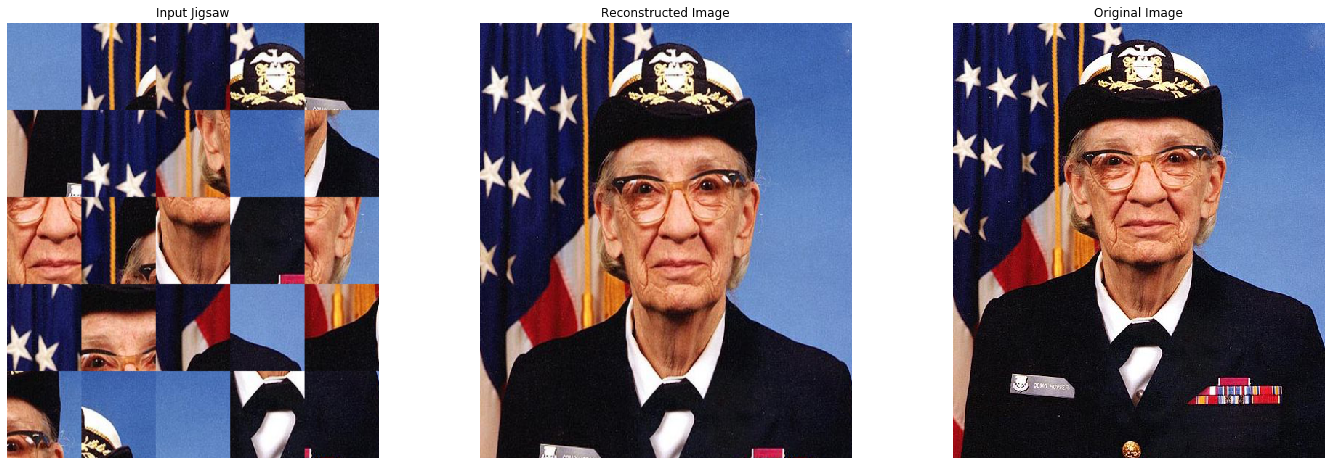

In [0]:
# Create your jigsaw puzzle solver here
class JigsawSolver(Jigsaw):
  def __init__(self,*args,**kwargs):
    super(JigsawSolver,self).__init__()
    self.mgc_rotations = [3, 0, 1, 2]
    self.dx = [0, -1, 0, 1]
    self.dy = [1, 0, -1, 0]
    self.reconstructed_image = []
    pass

  def plot(self):
    fig = plt.figure(figsize=(24,8))
    ax1 = fig.add_subplot(131)
    ax1.imshow(self.patches2image(self.jigsaw,self.original_size))
    ax1.axis('off')
    ax1.set_title("Input Jigsaw")
    ax2 = fig.add_subplot(132)
    ax2.imshow(self.reconstructed_image)
    ax2.axis('off')
    ax2.set_title("Reconstructed Image")
    ax3 = fig.add_subplot(133)
    ax3.imshow(self.image)
    ax3.axis('off')
    ax3.set_title("Original Image")
    plt.show()
  def mgc(self, i1, i2, o):
    rotations = self.mgc_rotations[o]
    i1 = np.rot90(i1, rotations)
    i2 = np.rot90(i2, rotations)
    grad = i1[:, -1] - i1[:, -2]
    mu = grad.mean(axis=0)
    s = np.cov(grad.T)
    grad_ij = i2[:, 1] - i1[:, -1]
    return np.trace(np.dot(grad_ij - mu, np.dot(np.linalg.pinv(s), (grad_ij - mu).T)))
  def compute_A(self, U, N, D):
    min_val = np.full((N,4), 1e6)
    idx = np.full((N,4), -1)
    for x in U:
      if D[x[0]][x[1]][x[2]] < min_val[x[0]][x[2]]:
        min_val[x[0]][x[2]] = D[x[0]][x[1]][x[2]]
        idx[x[0]][x[2]] = x[1]
    A = []
    for i in range(N):
      for j in range(4):
        if idx[i][j] != -1:
          A.append([i,idx[i][j], j])
    return A
  def lp_solver(self, N, A, w, n, m):
    x = cp.Variable(N)
    y = cp.Variable(N)
    # Check if fx, fy should be integer!!! 
    fx = cp.Variable((N*N,4))
    fy = cp.Variable((N*N,4))
    constraints = []
    a, b = 0, 0
    for v in A:
      a += w[v[0]][v[1]][v[2]] * fx[v[0]*N+v[1]][v[2]] 
      b += w[v[0]][v[1]][v[2]] * fy[v[0]*N+v[1]][v[2]] 
      constraints.append(x[v[0]] - x[v[1]] - self.dx[v[2]] <= fx[v[0]*N+v[1]][v[2]])
      constraints.append(-x[v[0]] + x[v[1]] + self.dx[v[2]] <= fx[v[0]*N+v[1]][v[2]])
      constraints.append(y[v[0]] - y[v[1]] - self.dy[v[2]] <= fy[v[0]*N+v[1]][v[2]])
      constraints.append(-y[v[0]] + y[v[1]] + self.dy[v[2]] <= fy[v[0]*N+v[1]][v[2]])
    objective = cp.Minimize(a + b)
    problem = cp.Problem(objective, constraints)
    problem.solve()
    print("problem status = ", problem.status)
    return x.value, y.value, fx.value, fy.value
  def rejected_matches(self, hx, hy, A, N):
    R = []
    for x in A:
      if hx[x[0]*N+x[1]][x[2]] > 1e-2:
        R.append(x)
      if hy[x[0]*N+x[1]][x[2]] > 1e-2:
        R.append(x)
    return R
  def solve(self):
    """
      Write your solver here
    """
    n, m = self.jigsaw.shape[0], self.jigsaw.shape[1]
    N = n*m
    # computing w matrix
    D = np.zeros((N, N, 4))
    w = np.zeros((N, N, 4))
    for i1 in range(N):
      for i2 in range(N):
        for k in range(4):
          D[i1][i2][k] = self.mgc(self.jigsaw[i1//n][i1%n], self.jigsaw[i2//n][i2%n], k)
    U = []
    for i1 in range(N):
      for i2 in range(N):
        for k in range(4):
          mn1 = min([D[i1][j][k] for j in range(N) if j != i2]) 
          mn2 = min([D[j][i2][k] for j in range(N) if j != i1]) 
          w[i1][i2][k] = min(mn1, mn2) / D[i1][i2][k]
          # Initializing U0
          U.append([i1,i2,k])
    # Initializing A0
    A = self.compute_A(U, N, D)
    # Initial solutions of x, y
    x, y, hx, hy = self.lp_solver(N, A, w, n, m)
    max_iter = 5
    for _ in range(max_iter):  
        R = self.rejected_matches( hx, hy, A, N)
        new_U = []
        # Updating U
        for v in U:
          if v not in R:
            new_U.append(v)
        U = new_U
        A = self.compute_A(U, N, D)
        x, y, hx, hy = self.lp_solver(N, A, w, n, m)
    x = np.round(x);
    y = np.round(y);
    patches = []
    for i in range(N):
      patches.append((x[i], y[i], i))
    patches.sort()
    final_img = np.zeros(self.jigsaw.shape)
    for i in range(n):
      for j in range(m):
        idx = patches[i + j*m][2]
        final_img[i][j] = self.jigsaw[idx//n][idx%n]
    self.reconstructed_image = self.patches2image(final_img, self.original_size)
solver = JigsawSolver(path=None)
solver.solve()
solver.plot()